In [1]:
pip install --upgrade typing-extensions

Note: you may need to restart the kernel to use updated packages.


# Chapter 8 
 Modern Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (September 15, 2022) <br>
ISBN-13: 978-3031075650

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors. We
"Warnings" are for information only and can usually be ignored. 
"Errors" will stop execution and need to be fixed in order to get results. 

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/mistat-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Check the errata at (https://gedeck.github.io/mistat-code-solutions/ModernStatistics/) and the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues to see if the issue is known and a solution available.
- Report the problem using the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [2]:
import os
os.environ['OUTDATED_IGNORE'] = '1'
import warnings
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)

# Modern analytic methods: Part II

In [3]:
import networkx as nx

import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mistat

# Functional Data Analysis

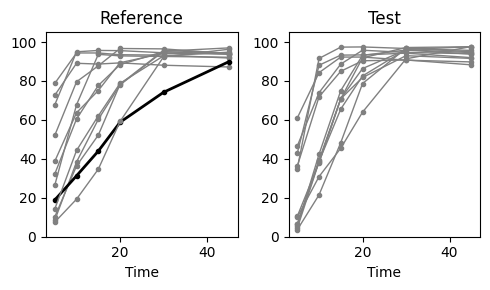

In [4]:
dissolution = mistat.load_data('DISSOLUTION.csv')

fig, axes = plt.subplots(ncols=2, figsize=(5, 3))
for label, group in dissolution.groupby('Label'):
  ax = axes[0] if label.endswith('R') else axes[1]
  color = 'black' if label == 'T5R' else 'grey'
  lw = 2 if label == 'T5R' else 1
  group.plot(x='Time', y='Data', color=color, ax=ax,
             marker='o', markersize=3, lw=lw)
for ax in axes:
  ax.get_legend().remove()
  ax.set_ylim(0, 105)
axes[0].set_title('Reference')
axes[1].set_title('Test')
plt.tight_layout()
plt.show()

In [5]:
from skfda import FDataGrid
from skfda.representation.interpolation import SplineInterpolation


# convert the data to FDataGrid
data = []
labels = []
names = []
for label, group in dissolution.groupby('Label'):
  data.append(group['Data'].values)
  labels.append('Reference' if label.endswith('R') else 'Test')
  names.append(label)
labels = np.array(labels)
grid_points = np.array(sorted(dissolution['Time'].unique()))
fd = FDataGrid(np.array(data), grid_points,
       dataset_name='Dissolution',
       argument_names=['Time'],
       coordinate_names=['Dissolution'],
       interpolation=SplineInterpolation(2))

In [6]:
from skfda.exploratory import stats

mean_ref = stats.mean(fd[labels=='Reference'])
mean_test = stats.mean(fd[labels=='Test'])
means = mean_ref.concatenate(mean_test)

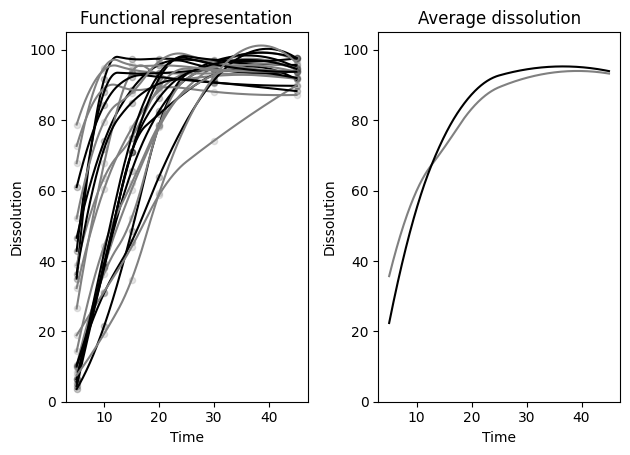

In [7]:
group_colors = {'Reference': 'grey', 'Test': 'black'}

fig, axes = plt.subplots(ncols=2)

fd.plot(axes=[axes[0]], group=labels, group_colors=group_colors)
for label, group in dissolution.groupby('Label'):
  color = 'grey' if label.endswith('R') else 'black'
  group.plot.scatter(x='Time', y='Data', c=color, ax=axes[0], alpha=0.2)

means.plot(axes=[axes[1]], group=['Reference', 'Test'],
           group_colors=group_colors)

fig.suptitle('')
axes[0].set_title('Functional representation')
axes[1].set_title('Average dissolution')
for ax in axes:
  ax.set_ylim(0, 105)
  ax.set_ylabel('Dissolution')
plt.tight_layout()
plt.show()

In [8]:
from skfda.preprocessing.registration import ShiftRegistration
shift_registration = ShiftRegistration()
fd_registered = shift_registration.fit_transform(fd)

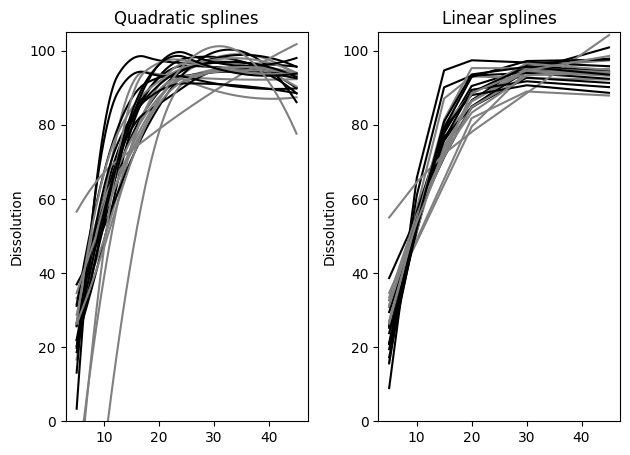

In [9]:
fig, axes = plt.subplots(ncols=2)
fd_registered.plot(axes=[axes[0]], group=labels, group_colors=group_colors)

# switch to linear spline interpolation
fd = FDataGrid(np.array(data), grid_points,
       dataset_name='Dissolution',
       argument_names=['Time'],
       coordinate_names=['Dissolution'],
       interpolation=SplineInterpolation(1, monotone=True))
fd_registered = shift_registration.fit_transform(fd)
fd_registered.plot(axes=[axes[1]], group=labels, group_colors=group_colors)

fig.suptitle('')
axes[0].set_title('Quadratic splines')
axes[1].set_title('Linear splines')
for ax in axes:
  ax.set_ylim(0, 105)
  ax.set_ylabel('Dissolution')
plt.tight_layout()
plt.show()

In [10]:
from skfda.exploratory.outliers import BoxplotOutlierDetector

out_detector = BoxplotOutlierDetector()
outliers = out_detector.fit_predict(fd)
print('Outlier:')
for name, outlier in zip(names, outliers):
  if outlier == 1:
    continue
  print('  ', name)

Outlier:
   T5R


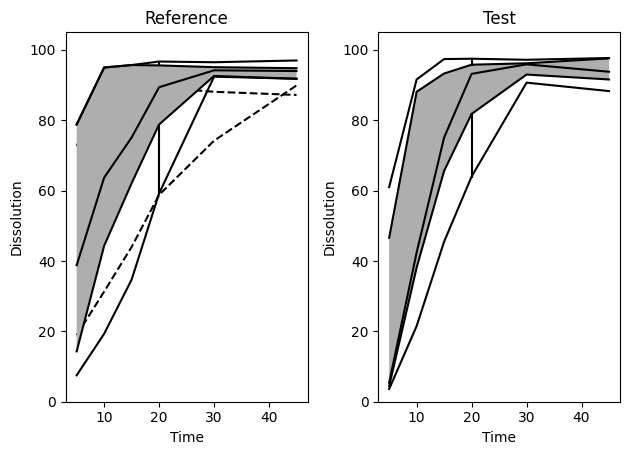

In [11]:
from skfda.exploratory.visualization import Boxplot
from matplotlib.colors import LinearSegmentedColormap

def addBoxplot(fd, ax):
  cm = LinearSegmentedColormap.from_list('fda', ['grey', 'lightgrey'])
  boxplot = Boxplot(fd, axes=[ax])
  boxplot.barcol = 'black'
  boxplot.outliercol = 'black'
  boxplot.colormap = cm
  boxplot.plot()

fig, axes = plt.subplots(ncols=2)
addBoxplot(fd[labels=='Reference'], axes[0])
addBoxplot(fd[labels=='Test'], axes[1])
fig.suptitle('')
axes[0].set_title('Reference')
axes[1].set_title('Test')
for ax in axes:
  ax.set_ylim(0, 105)
  ax.set_ylabel('Dissolution')
plt.tight_layout()
plt.show()

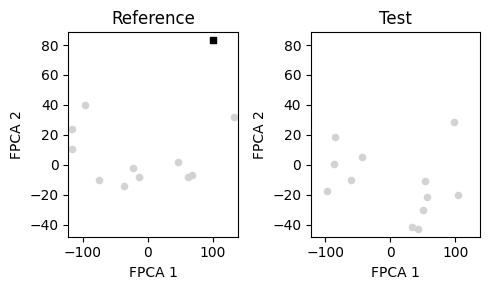

In [12]:
from skfda.preprocessing.dim_reduction import FPCA
fpca = FPCA(n_components=2)
fpca.fit(fd)

df = pd.DataFrame(fpca.transform(fd), columns=['FPCA 1', 'FPCA 2'])
df['labels'] = labels
df['names'] = names

lim1 = (min(df['FPCA 1'])-5, max(df['FPCA 1'])+5)
lim2 = (min(df['FPCA 2'])-5, max(df['FPCA 2'])+5)
fig, axes = plt.subplots(ncols=2, figsize=(5, 3))
for ax, label in zip(axes, ['Reference', 'Test']):
  subset = df[df.labels == label]
  subset.plot.scatter(x='FPCA 1', y='FPCA 2', ax=ax, color='lightgrey')
  ax.set_title(label)
  ax.set_xlim(*lim1)
  ax.set_ylim(*lim2)
outlier = df[df.names == 'T5R']
outlier.plot.scatter(x='FPCA 1', y='FPCA 2', color='black',
  marker='s', ax=axes[0])

plt.tight_layout()
plt.show()

# Text Analytics

## Pubmed COPD (example 1)
The dataset consists of literature abstracts downloaded from pubmed using the query "COPD" (https://pubmed.ncbi.nlm.nih.gov/?term=copd)

In [13]:
abstracts = pd.read_csv('PUBMED-COPD.csv.gz')
print(abstracts.shape)
abstracts.head()

(10, 3)


,Unnamed: 0,PMID,Abstract
0,0,36656661,The observational retrospective cohort Study o...
1,1,36655999,Chronic obstructive pulmonary disease (COPD) i...
2,2,36655947,This study aimed to assess the time and functi...
3,3,36655862,Chronic obstructive pulmonary disease (COPD) r...
4,4,36655855,A systematic review aimed to investigate the a...


In [14]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def preprocessor(text):
    text = text.lower()
    text = re.sub(r'\d[\d,]*', '', text)
    text = '\n'.join(line for line in text.split('\n')
                     if not line.startswith('ntsb'))
    return text

vectorizer = CountVectorizer(preprocessor=preprocessor,
                             # Restrict to words that have at least two characters
                             token_pattern=r'(?u)\b\w\w{2,10}\b',
                             stop_words='english')
counts = vectorizer.fit_transform(abstracts['Abstract'])
print('shape of DTM', counts.shape)
print('total number of terms', np.sum(counts))

shape of DTM (10, 621)
total number of terms 1214


In [15]:
termCounts = np.array(counts.sum(axis=0)).flatten()
topCounts = termCounts.argsort()
terms = vectorizer.get_feature_names_out()
for n in reversed(topCounts[-10:]):
  print(f'{terms[n]:10s}  {termCounts[n]:5d}')

copd           42
patients       28
lung           15
covid          15
genes          11
disease        11
factors        10
study          10
chronic        10
pulmonary      10


In [16]:
tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
tfidf = tfidfTransformer.fit_transform(counts)

### Identify terms in a given abstract with high tf-idf scores
Here is an example abstract

In [17]:
abstract = abstracts['Abstract'][0]
print(abstract)

The observational retrospective cohort Study on HEalthcare Resource utiLization (HCRU) related to exacerbatiOns in patients with COPD (SHERLOCK; D5980R00014) evaluated exacerbation-related HCRU and costs using the U.K. National Health Service Greater Glasgow and Clyde Health Board data. Patients (≥40 years) with COPD were stratified by exacerbations one year before the index date: Group A (none), B (1 moderate), C (1 severe) and D (≥2 moderate and/or severe). All-cause and COPD-related HCRU and costs were assessed over 36 months. Adjusted rate ratios (RRs) or relative costs versus Group A were estimated using generalized linear models with appropriate distributions and link functions. The study included 22 462 patients (Group A, n = 7788; B, n = 5151; C, n = 250 and D, n = 9273). At 12 months, RRs (95% CI) versus Group A for all-cause and COPD-related HCRU, respectively, were highest in Groups C (1.28 [1.18, 1.39] and 1.18 [1.09, 1.29]) and D (1.26 [1.23, 1.28] and 1.29 [1.26, 1.31]). 

In [18]:
terms = vectorizer.get_feature_names_out()
docterms = counts[0,:].nonzero()[1]
df = pd.DataFrame({
  'Terms': [terms[i] for i in docterms],
  'Counts': [counts[0, i] for i in docterms],
  'TF-IDF': [tfidf[0, i] for i in docterms],
  'weight': [tfidf[0, i] / counts[0, i] for i in docterms]
})
df = df.sort_values('TF-IDF', ascending=False)

In [19]:
df.head(10)

,Terms,Counts,TF-IDF,weight
6,related,7,23.118096,3.302585
26,group,8,20.875503,2.609438
5,hcru,6,19.815511,3.302585
11,costs,6,19.815511,3.302585
31,months,4,13.210340,3.302585
29,cause,3,9.907755,3.302585
37,versus,3,9.907755,3.302585
8,copd,6,7.338861,1.223144
48,general,2,6.605170,3.302585
36,relative,2,6.605170,3.302585


### Use SVD to identify topics

In [20]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
svd = TruncatedSVD(10)
tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(tfidf)
print(lsa_tfidf.shape)

(10, 10)


In [21]:
terms = vectorizer.get_feature_names_out()
data = {}
for i, component in enumerate(svd.components_, 1):
  compSort = component.argsort()
  idx = list(reversed(compSort[-10:]))
  data[f'Topic {i}'] = [terms[n] for n in idx]
  data[f'Loading {i}'] = [component[n] for n in idx]
df = pd.DataFrame(data)

In [22]:
df.round(4)

,Topic 1,Loading 1,Topic 2,Loading 2,Topic 3,Loading 3,Topic 4,Loading 4,Topic 5,Loading 5,Topic 6,Loading 6,Topic 7,Loading 7,Topic 8,Loading 8,Topic 9,Loading 9,Topic 10,Loading 10
0,covid,0.3287,lung,0.2768,related,0.3216,model,0.3228,model,0.2610,genes,0.2528,tslp,0.2413,rbps,0.2411,disorder,0.2961,recovery,0.2505
1,copd,0.2804,rbps,0.1982,group,0.3084,aecopd,0.2152,aecopd,0.1740,expression,0.2174,asthma,0.2413,disorder,0.2145,bipolar,0.2961,time,0.1812
2,patients,0.2523,genes,0.1895,hcru,0.2756,diagnosis,0.2152,diagnosis,0.1740,expressed,0.1553,anti,0.1810,bipolar,0.2145,tissue,0.1295,copd,0.1399
3,time,0.1783,tissue,0.1839,costs,0.2756,fatigue,0.2065,svm,0.1305,methylated,0.1553,clinical,0.1491,studies,0.1993,studies,0.1254,terms,0.1252
4,death,0.1575,cancer,0.1586,months,0.1837,capacity,0.1652,indicators,0.1305,model,0.1395,evidence,0.1402,cancer,0.1929,associated,0.1193,times,0.1252
5,factors,0.1562,ctsk,0.1533,cause,0.1378,exercise,0.1652,sets,0.1305,signaling,0.1242,fatigue,0.1212,pathogenic,0.1447,macrophages,0.1079,cov,0.1252
6,risk,0.1389,macrophages,0.1533,versus,0.1378,frs,0.1614,frs,0.1305,diagnosis,0.0930,treatments,0.1206,mechanisms,0.1447,ctsk,0.1079,people,0.1252
7,bipolar,0.1375,expression,0.1401,relative,0.0919,sets,0.1614,clinical,0.1098,aecopd,0.0930,epithelial,0.1206,common,0.0964,cases,0.0987,patients,0.1051
8,disorder,0.1375,copd,0.1328,rrs,0.0919,svm,0.1614,tissue,0.0966,indicators,0.0698,function,0.1206,oxidative,0.0964,fold,0.0987,higher,0.0942
9,studies,0.1310,phagosomal,0.1226,general,0.0919,indicators,0.1614,asthma,0.0950,svm,0.0698,improving,0.1206,shared,0.0964,incidence,0.0987,death,0.0822


## Pubmed Humira (example 2)
This dataset contains abstracts from pubmed for the top-selling drug Humira.

In [23]:
abstracts = pd.read_csv('PUBMED-HUMIRA.csv.gz')
print(abstracts.shape)

(3477, 3)


In [24]:
def preprocessor(text):
    text = text.lower()
    text = re.sub(r'\d[\d,]*', '', text)
    text = '\n'.join(line for line in text.split('\n')
                     if not line.startswith('ntsb'))
    return text

vectorizer = CountVectorizer(preprocessor=preprocessor,
                             # Restrict to words that have at least two characters
                             token_pattern=r'(?u)\b\w\w{2,10}\b',
                             stop_words='english')
counts = vectorizer.fit_transform(abstracts['Abstract'])
print('shape of DTM', counts.shape)
print('total number of terms', np.sum(counts))

shape of DTM (3477, 13351)
total number of terms 447292


In [25]:
termCounts = np.array(counts.sum(axis=0)).flatten()
topCounts = termCounts.argsort()
terms = vectorizer.get_feature_names_out()
for n in reversed(topCounts[-10:]):
    print(f'{terms[n]:10s}  {termCounts[n]:5d}')

patients    12481
adalimumab   7248
treatment    6309
disease      4713
anti         3817
tnf          3621
therapy      3175
study        3011
clinical     3002
results      2832


In [26]:
tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
tfidf = tfidfTransformer.fit_transform(counts)

### identify terms in a given abstract with high tf-idf scores 

In [27]:
abstract = abstracts['Abstract'][0]
print(abstract)

Tumor necrosis factor (TNF) inhibitors improved clinical outcomes for patients with psoriasis but are limited by their high cost. There are several biosimilar options approved for the treatment of psoriasis which provides a lower-cost alternative and the potential to increase treatment availability for both biologically naïve and bioexperienced patients. Numerous phase III randomized controlled trials (RCTs) have investigated the effects of switching from biologics to biosimilars; biosimilars had comparable safety and efficacy to their reference products. Real-world evidence may provide complementary information on the expected performance of biosimilars. In this literature review, we analyzed data from real-world studies on switching from biologics for psoriasis to their biosimilars. Effectiveness and safety profiles were comparable when switching from biologics to biosimilars of adalimumab, etanercept, and infliximab. These studies are limited by their sample sizes, duration of follo

In [28]:
terms = vectorizer.get_feature_names_out()
docterms = counts[0,:].nonzero()[1]
df = pd.DataFrame({
  'Terms': [terms[i] for i in docterms],
  'Counts': [counts[0, i] for i in docterms],
  'TF-IDF': [tfidf[0, i] for i in docterms],
  'weight': [tfidf[0, i] / counts[0, i] for i in docterms]
})
df = df.sort_values('TF-IDF', ascending=False)

In [29]:
df.head(10)

,Terms,Counts,TF-IDF,weight
33,biosimilars,5,19.508259,3.901652
31,switching,4,15.208268,3.802067
40,world,3,10.909417,3.636472
9,psoriasis,4,10.486363,2.621591
39,real,3,9.778567,3.259522
32,biologics,3,8.256024,2.752008
34,comparable,2,7.877979,3.938989
12,cost,2,7.256944,3.628472
13,biosimilar,2,7.059815,3.529908
10,limited,2,6.893630,3.446815


### Use SVD to identify topics

In [30]:
svd = TruncatedSVD(10)
tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(tfidf)
print(lsa_tfidf.shape)

(3477, 10)


In [31]:
terms = vectorizer.get_feature_names_out()
data = {}
for i, component in enumerate(svd.components_, 1):
  compSort = component.argsort()
  idx = list(reversed(compSort[-10:]))
  data[f'Topic {i}'] = [terms[n] for n in idx]
  data[f'Loading {i}'] = [component[n] for n in idx]
df = pd.DataFrame(data)

In [32]:
df.round(4) 

,Topic 1,Loading 1,Topic 2,Loading 2,Topic 3,Loading 3,Topic 4,Loading 4,Topic 5,Loading 5,Topic 6,Loading 6,Topic 7,Loading 7,Topic 8,Loading 8,Topic 9,Loading 9,Topic 10,Loading 10
0,patients,0.3397,psoriasis,0.3304,ada,0.3696,uveitis,0.6205,ada,0.2807,ada,0.4097,biosimilars,0.3626,ada,0.3125,mtx,0.3028,uveitis,0.3682
1,treatment,0.1782,pasi,0.2329,week,0.2475,jia,0.2363,survival,0.2489,psoriasis,0.3542,biosimilar,0.3009,mtx,0.3101,ada,0.2155,anti,0.2429
2,anti,0.1697,week,0.1479,patients,0.1827,ocular,0.1240,tnfi,0.1936,pasi,0.2022,ada,0.2677,tnfi,0.2568,ifx,0.1548,pasi,0.1646
3,tnf,0.1674,secukinumab,0.1328,mtx,0.1755,eyes,0.1148,persistence,0.1722,ifx,0.1549,originator,0.1828,tnf,0.2061,tofacitinib,0.1330,jia,0.1566
4,adalimumab,0.1607,efficacy,0.1197,remission,0.1575,systemic,0.1130,biologic,0.1636,week,0.1501,safety,0.1469,psoriasis,0.1619,biologic,0.1247,tnf,0.1483
5,disease,0.1525,guselkumab,0.1191,ifx,0.1257,mtx,0.1130,drug,0.1633,guselkumab,0.0996,studies,0.1283,levels,0.1199,biologics,0.1200,survival,0.1261
6,psoriasis,0.1392,ustekinumab,0.1165,response,0.1091,anterior,0.1079,months,0.1308,uveitis,0.0790,ibd,0.1276,inhibitors,0.1193,response,0.1120,drug,0.1208
7,therapy,0.1352,ixekizumab,0.1134,group,0.1081,visual,0.1029,patients,0.1307,severe,0.0753,reference,0.1232,anti,0.1028,rcts,0.1077,biosimilar,0.1004
8,ada,0.1241,safety,0.1120,weeks,0.1076,idiopathic,0.0981,ifx,0.1160,plaque,0.0720,cost,0.1173,antibodies,0.0991,ibd,0.1056,week,0.0999
9,response,0.1165,placebo,0.1090,activity,0.0894,juvenile,0.0893,ustekinumab,0.0998,weeks,0.0655,ifx,0.1109,cells,0.0978,trials,0.1022,biosimilars,0.0952


## Devices (example 3)

In [33]:
devices = pd.read_csv('DEVICES.csv.gz')
print(devices.shape)

(27594, 9)


In [34]:
def preprocessor(text):
    text = text.lower()
    text = re.sub(r'\d[\d,]*', '', text)
    text = '\n'.join(line for line in text.split('\n')
                     if not line.startswith('ntsb'))
    return text

vectorizer = CountVectorizer(preprocessor=preprocessor,
                             stop_words='english')
counts = vectorizer.fit_transform(devices['Long Desc'])
print('shape of DTM', counts.shape)
print('total number of terms', np.sum(counts))

shape of DTM (27594, 994)
total number of terms 232251


In [35]:
termCounts = np.array(counts.sum(axis=0)).flatten()
topCounts = termCounts.argsort()
terms = vectorizer.get_feature_names_out()
for n in reversed(topCounts[-10:]):
    print(f'{terms[n]:10s}  {termCounts[n]:5d}')

procedures  12817
established   8404
device       6490
quality      5694
adequately   5049
design       4010
documented   3931
implemented   3353
product      3280
corrective   3156


In [36]:
tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
tfidf = tfidfTransformer.fit_transform(counts)

### Identify terms in a given description with high tf-idf scores

In [37]:
docIndex = 2
devices['Long Desc'][docIndex]

'The corrective and preventive procedures addressing the analysis of sources of quality data to identify existing and potential causes of nonconforming product or other quality problems were not established and implemented.'

In [38]:
terms = vectorizer.get_feature_names_out()
docterms = counts[docIndex,:].nonzero()[1]
df = pd.DataFrame({
  'Terms': [terms[i] for i in docterms],
  'Counts': [counts[docIndex, i] for i in docterms],
  'TF-IDF': [tfidf[docIndex, i] for i in docterms],
  'weight': [tfidf[docIndex, i] / counts[docIndex, i] for i in docterms]
})
df = df.sort_values('TF-IDF', ascending=False)

In [39]:
df

,Terms,Counts,TF-IDF,weight
7,quality,2,5.833323,2.916662
10,existing,1,5.322720,5.322720
9,identify,1,5.204330,5.204330
6,sources,1,5.185099,5.185099
5,analysis,1,5.096303,5.096303
11,potential,1,4.926404,4.926404
12,causes,1,4.893852,4.893852
8,data,1,4.806989,4.806989
4,addressing,1,4.632309,4.632309
15,problems,1,4.434132,4.434132


### SVD

In [40]:
svd = TruncatedSVD(10)
tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(tfidf)
print(lsa_tfidf.shape)

(27594, 10)


In [41]:
terms = vectorizer.get_feature_names_out()
data = {}
for i, component in enumerate(svd.components_, 1):
  compSort = component.argsort()
  idx = list(reversed(compSort[-10:]))
  data[f'Topic {i}'] = [terms[n] for n in idx]
  data[f'Loading {i}'] = [component[n] for n in idx]
df = pd.DataFrame(data)

In [42]:
df.round(4)

,Topic 1,Loading 1,Topic 2,Loading 2,Topic 3,Loading 3,Topic 4,Loading 4,Topic 5,Loading 5,Topic 6,Loading 6,Topic 7,Loading 7,Topic 8,Loading 8,Topic 9,Loading 9,Topic 10,Loading 10
0,procedures,0.4327,corrective,0.4310,device,0.4664,complaints,0.3097,quality,0.5833,written,0.4704,documented,0.3045,product,0.3655,adequately,0.2318,control,0.3025
1,established,0.4079,preventive,0.4169,record,0.3865,evaluating,0.2713,audits,0.2896,mdr,0.4358,fully,0.2934,conform,0.2822,verified,0.1854,process,0.2906
2,adequately,0.3035,action,0.3459,master,0.2391,reviewing,0.2576,implemented,0.1167,developed,0.4333,results,0.2857,specified,0.2754,validated,0.1842,specifications,0.2212
3,corrective,0.2843,actions,0.1521,history,0.2354,receiving,0.2565,mdr,0.1138,implemented,0.1979,activities,0.2646,requirements,0.2281,according,0.1840,actions,0.1916
4,preventive,0.2778,activities,0.1273,maintained,0.1717,complaint,0.2389,written,0.1135,procedures,0.1814,process,0.2495,acceptance,0.2259,subsequent,0.1793,necessary,0.1796
5,action,0.2348,implementing,0.1011,does,0.1501,handling,0.1895,effective,0.1120,control,0.1060,written,0.1946,services,0.2141,inspection,0.1771,implemented,0.1727
6,design,0.1622,addressing,0.0712,manufactured,0.1256,formally,0.1676,maintained,0.1114,maintained,0.0780,mdr,0.1935,purchased,0.2139,test,0.1731,implementing,0.1539
7,quality,0.1526,documented,0.0593,demonstrate,0.1236,unit,0.1659,objectives,0.1079,design,0.0760,developed,0.1718,received,0.2137,established,0.1731,complete,0.1511
8,control,0.1512,results,0.0476,activities,0.1174,designated,0.1592,conducting,0.1051,document,0.0644,test,0.1571,ensure,0.2080,fully,0.1364,corrective,0.1219
9,documented,0.1440,problems,0.0350,accordance,0.1149,device,0.1446,record,0.0966,implementing,0.0513,validated,0.1548,documented,0.1577,process,0.1040,preventive,0.1139


## Bayesian Networks
See notebook [Bioreactor.ipynb](Bioreactor.ipynb)

## Causality Models

In [43]:
distTower = mistat.load_data('DISTILLATION-TOWER.csv')
distTower = distTower.set_index('Date')
subset = ['VapourPressure', 'Temp1', 'Temp2', 'Temp3', 'Temp4', 'Temp5',
          'Temp6', 'Temp7', 'Temp8', 'Temp9', 'Temp10','Temp11','Temp12']
distTower = distTower[subset]
results = []
for c in subset[1:]:
    # use pct_change to make time series stationary
    data = distTower[["VapourPressure", c]].pct_change().dropna()
    gc_res = grangercausalitytests(data, 10, verbose=False)
    results.append({f'lag {i}': gc[0]['ssr_ftest'][1]
                    for i, gc in gc_res.items()})
df = pd.DataFrame(results, index=subset[1:])
df['id'] = df.index

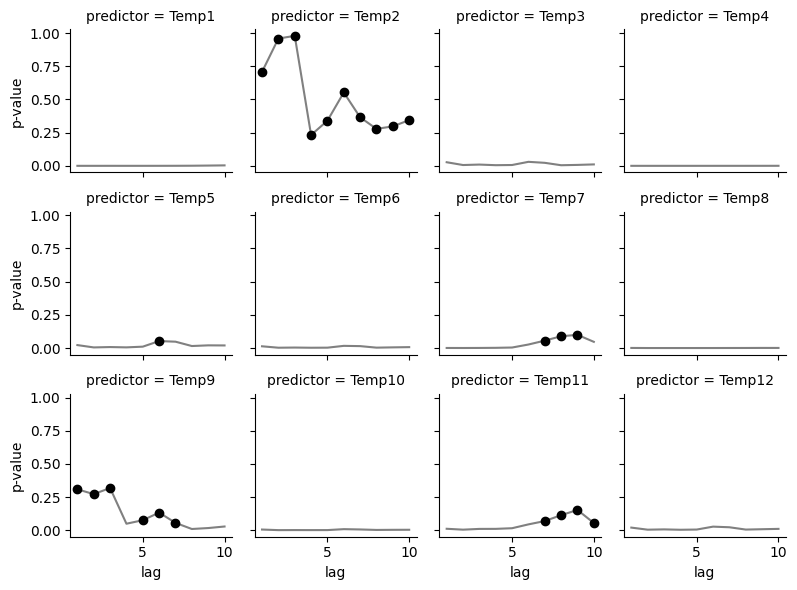

In [44]:
df = pd.wide_to_long(df, 'lag ', 'id', 'VapourPressure')
df = df.reset_index()
df.columns = ('predictor', 'lag', 'p-value')

def plotLag(x, y, **kwargs):
    ax = plt.gca()
    ax.plot(x, y, **kwargs)
    sig = y > 0.05
    ax.scatter(x[sig], y[sig], color='black',zorder=10)

g = sns.FacetGrid(df, col="predictor", col_wrap=4, height=2)
g.map(plotLag, 'lag', 'p-value', color='grey')
plt.show()